In [ ]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
import random
import tensorflow as tf
import os

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [ ]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the Dataset
FILE_PATH = '/content/drive/MyDrive/Forecasting/household_power_consumption.txt'
df = pd.read_csv(
    FILE_PATH,
    sep=";",
    na_values="?",
    low_memory=False
)

print("Original shape:", df.shape)
df.info()

Original shape: (2075259, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


In [ ]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


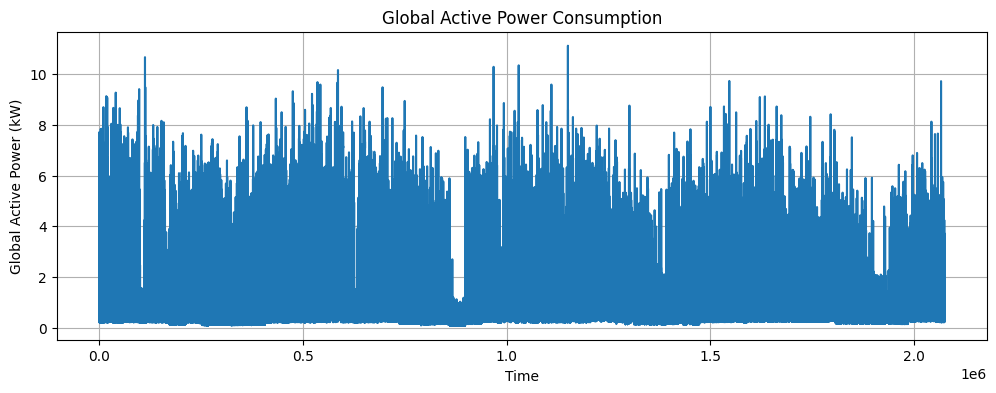

In [ ]:
plt.figure(figsize=(12, 4))
df['Global_active_power'].plot()
plt.title("Global Active Power Consumption")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.grid()
plt.show()


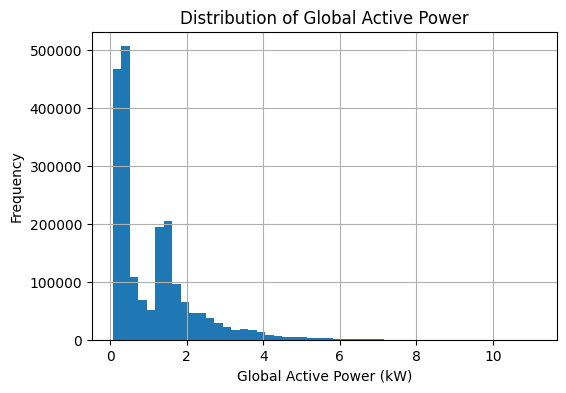

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df['Global_active_power'].dropna(), bins=50)
plt.title("Distribution of Global Active Power")
plt.xlabel("Global Active Power (kW)")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [ ]:
# Handling date and time
df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)

df.set_index("Datetime", inplace=True)
df.drop(["Date", "Time"], axis=1, inplace=True)
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# Converting to Numeric values & Handling the missing values
df = df.apply(pd.to_numeric)
df.fillna(method="ffill", inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


/tmp/ipython-input-3060162278.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


In [ ]:
#resampling the data minute data into hourly
df_hourly = df.resample('h').agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
})

print("Hourly shape:", df_hourly.shape)

# Log Transforming the Target data to Stabilize Peaks( This improved the result a bit than the previous)
df_hourly['Global_active_power'] = np.log1p(df_hourly['Global_active_power'])


Hourly shape: (34589, 7)


In [ ]:
# Time-based Feature Engineering
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly['is_weekend'] = (df_hourly.index.dayofweek >= 5).astype(int)


In [ ]:
df_hourly.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,is_weekend
Datetime,,,,,,,,,,
2006-12-16 17:00:00,1.653051,0.229000,234.643889,18.100000,0.0,19.0,607.0,17,5,1
2006-12-16 18:00:00,1.533032,0.080033,234.580167,15.600000,0.0,403.0,1012.0,18,5,1
2006-12-16 19:00:00,1.481658,0.085233,233.232500,14.503333,0.0,86.0,1001.0,19,5,1
2006-12-16 20:00:00,1.451278,0.075100,234.071500,13.916667,0.0,0.0,1007.0,20,5,1
2006-12-16 21:00:00,1.400312,0.076667,237.158667,13.046667,0.0,25.0,1033.0,21,5,1
2006-12-16 22:00:00,1.163192,0.056167,238.760000,9.523333,0.0,8.0,266.0,22,5,1
2006-12-16 23:00:00,1.118938,0.071433,240.619667,8.896667,0.0,5.0,0.0,23,5,1
2006-12-17 00:00:00,1.058646,0.102433,240.961833,8.126667,0.0,28.0,0.0,0,6,1
2006-12-17 01:00:00,1.470038,0.136933,240.448333,14.246667,0.0,1514.0,0.0,1,6,1


In [ ]:
#selecting the features for the prediction.
features = [
    'Global_active_power',
    'Voltage',
    'Global_reactive_power',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3',
    'hour',
    'dayofweek',
    'is_weekend'
]
# Converting the features into hourly sample.
data = df_hourly[features]



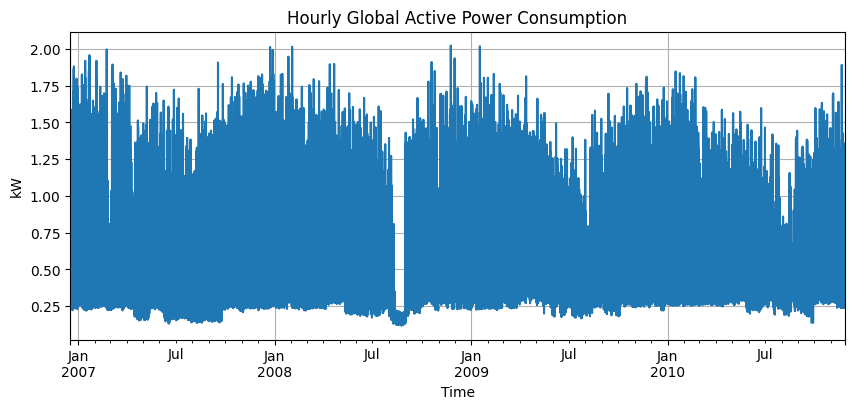

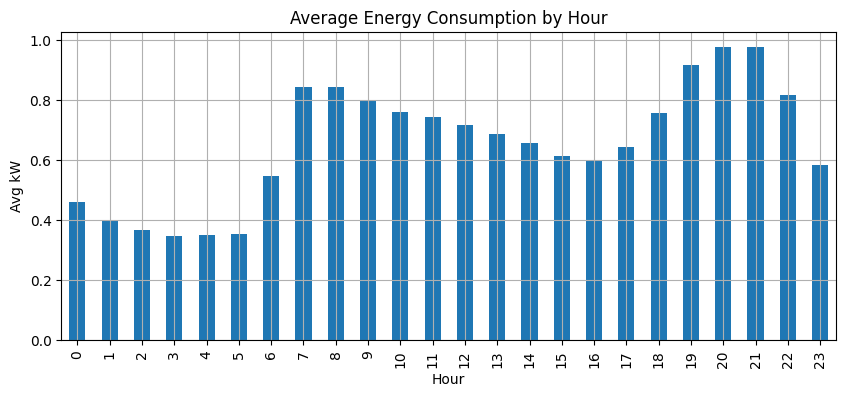

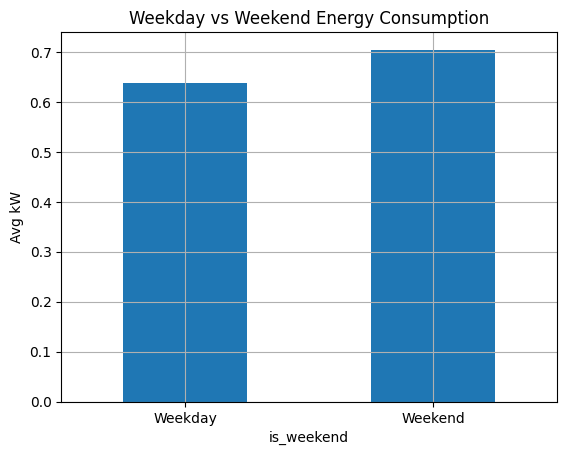

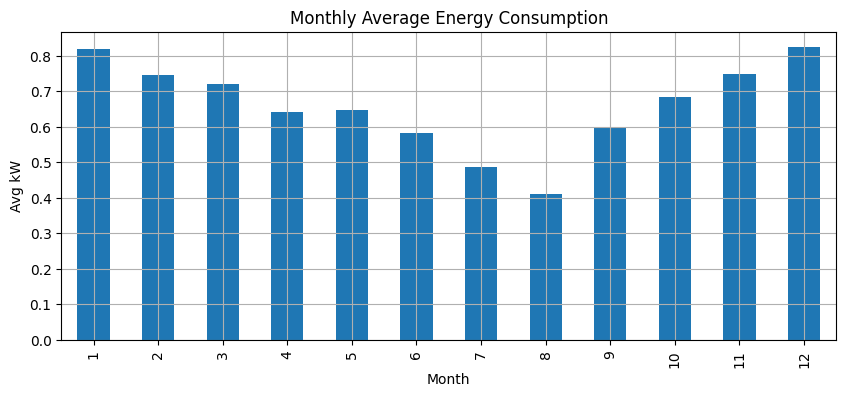

In [ ]:
#some important plots of Exploratory Data Analysis (EDA)
# Hourly Global Active power Consumption
plt.figure(figsize=(10,4))
df_hourly['Global_active_power'].plot()
plt.title("Hourly Global Active Power Consumption")
plt.xlabel("Time")
plt.ylabel("kW")
plt.grid()
plt.show()

# Avg by Hour
df_hourly.groupby('hour')['Global_active_power'].mean().plot(kind='bar', figsize=(10,4))
plt.title("Average Energy Consumption by Hour")
plt.xlabel("Hour")
plt.ylabel("Avg kW")
plt.grid()
plt.show()

# Weekday vs Weekend
df_hourly.groupby('is_weekend')['Global_active_power'].mean().plot(kind='bar')
plt.xticks([0,1], ['Weekday','Weekend'], rotation=0)
plt.title("Weekday vs Weekend Energy Consumption")
plt.ylabel("Avg kW")
plt.grid()
plt.show()

# Monthly Consumption
df_hourly['month'] = df_hourly.index.month
df_hourly.groupby('month')['Global_active_power'].mean().plot(kind='bar', figsize=(10,4))
plt.title("Monthly Average Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Avg kW")
plt.grid()
plt.show()


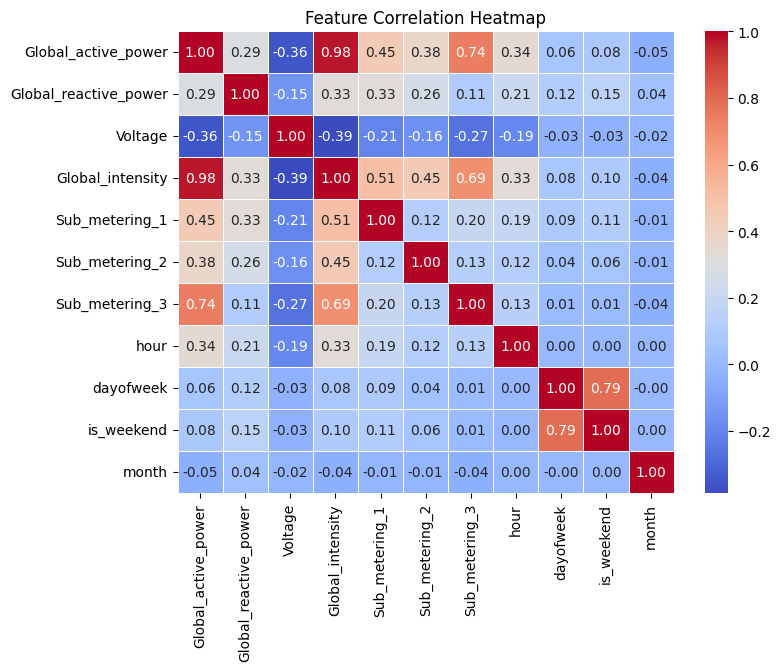

In [ ]:
#Correlation Analysis
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_hourly.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# Train / Validation / Test Split
total_len = len(data)

train_end = int(total_len * 0.70)
val_end   = int(total_len * 0.85)

train_data = data.iloc[:train_end]
val_data   = data.iloc[train_end:val_end]
test_data  = data.iloc[val_end:]

print("Train / Val / Test sizes:",
      len(train_data), len(val_data), len(test_data))


Train / Val / Test sizes: 24212 5188 5189


In [ ]:
# Scaling the data.
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
val_scaled   = scaler.transform(val_data)
test_scaled  = scaler.transform(test_data)


In [ ]:
# 10. Sequence Creation (Multivariate)
def create_sequences(data, target_col_idx, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        y.append(data[i, target_col_idx])
    return np.array(X), np.array(y)

#window size defined.
window_size = 48
target_col_idx = features.index('Global_active_power')

X_train, y_train = create_sequences(train_scaled, target_col_idx, window_size)
X_val,   y_val   = create_sequences(val_scaled,   target_col_idx, window_size)
X_test,  y_test  = create_sequences(test_scaled,  target_col_idx, window_size)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)



X_train: (24164, 48, 10) y_train: (24164,)
X_val  : (5140, 48, 10) y_val  : (5140,)
X_test : (5141, 48, 10) y_test : (5141,)


# **IMPLEMENTING THE LSTM MODEL**

In [ ]:
from tensorflow.keras.layers import Dropout

#creating the lstm model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    LSTM(32),
    Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 48, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model Training
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0313 - mae: 0.1410 - val_loss: 0.0149 - val_mae: 0.0949
Epoch 2/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0158 - mae: 0.0959 - val_loss: 0.0142 - val_mae: 0.0916
Epoch 3/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0145 - mae: 0.0897 - val_loss: 0.0138 - val_mae: 0.0891
Epoch 4/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0140 - mae: 0.0874 - val_loss: 0.0135 - val_mae: 0.0872
Epoch 5/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0137 - mae: 0.0860 - val_loss: 0.0133 - val_mae: 0.0863
Epoch 6/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0135 - mae: 0.0850 - val_loss: 0.0132 - val_mae: 0.0858
Epoch 7/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0133 - mae: 0.0842 - val_loss: 0.0131 - val_mae: 0.0855
Epoch 8/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0132 - mae: 0.0836 - val_loss: 0.0130 - val_mae: 0.0851
Epoch 9/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - 

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print("Test MSE (scaled):", test_loss)
print("Test MAE (scaled):", test_mae)


Test MSE (scaled): 0.01142823975533247
Test MAE (scaled): 0.07739149779081345


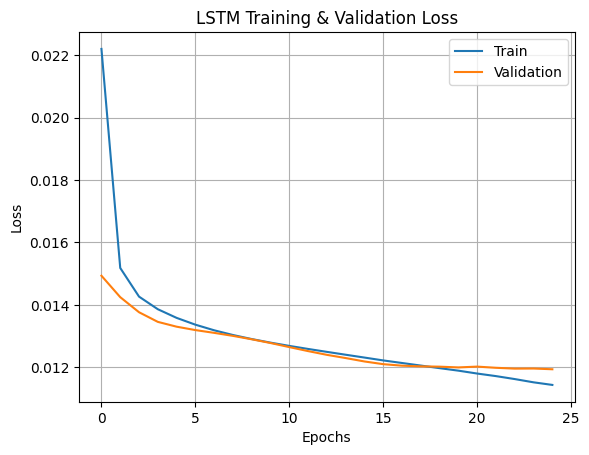

In [ ]:
# LSTM Loss Curve
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:
y_pred_scaled = model.predict(X_test)

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
num_features = X_train.shape[2]

# Inverse Scaling
y_pred_log = scaler.inverse_transform(
    np.hstack([
        y_pred_scaled,
        np.zeros((y_pred_scaled.shape[0], num_features - 1))
    ])
)[:, 0]

y_test_log = scaler.inverse_transform(
    np.hstack([
        y_test.reshape(-1, 1),
        np.zeros((y_test.shape[0], num_features - 1))
    ])
)[:, 0]


In [ ]:
y_pred_final = np.expm1(y_pred_log)
y_test_final = np.expm1(y_test_log)


In [ ]:
#final results (RMSE and MAE scores)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
mae  = mean_absolute_error(y_test_final, y_pred_final)

print("FINAL TEST RMSE (kW):", rmse)
print("FINAL TEST MAE  (kW):", mae)

FINAL TEST RMSE (kW): 0.4616637946102278
FINAL TEST MAE  (kW): 0.3074595932575377


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_final, y_pred_final)

print("LSTM R² Score:", r2)


LSTM R² Score: 0.5697977587714418


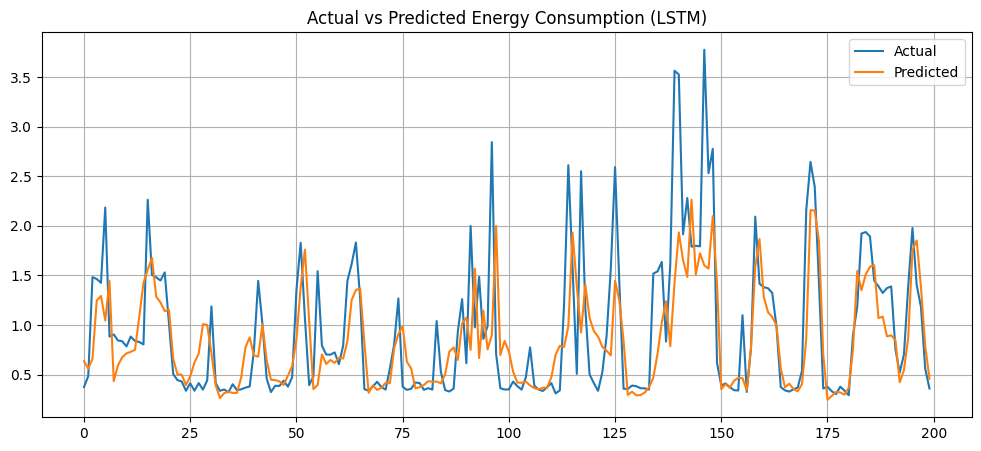

In [ ]:
# Actual vs Predicted (LSTM)
plt.figure(figsize=(12,5))
plt.plot(y_test_final[:200], label="Actual")
plt.plot(y_pred_final[:200], label="Predicted")
plt.title("Actual vs Predicted Energy Consumption (LSTM)")
plt.legend()
plt.grid()
plt.show()


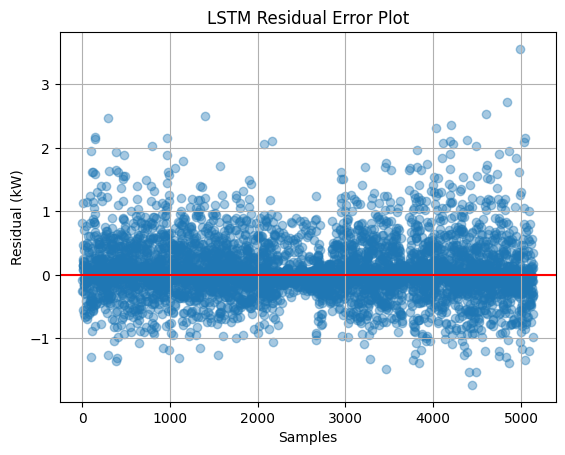

In [ ]:
# Residual Error Plot (LSTM)
residuals = y_test_final - y_pred_final

plt.scatter(range(len(residuals)), residuals, alpha=0.4)
plt.axhline(0, color='red')
plt.title("LSTM Residual Error Plot")
plt.xlabel("Samples")
plt.ylabel("Residual (kW)")
plt.grid()
plt.show()


# **IMPLEMENTING THE GRU MODEL**

In [ ]:
# GRU Model
from tensorflow.keras.layers import GRU
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    GRU(32),
    Dense(1)
])

gru_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

gru_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 48, 64)         │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,033 (93.88 KB)

 Trainable params: 24,033 (93.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Trainning the GRU Model.
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0249 - mae: 0.1226 - val_loss: 0.0152 - val_mae: 0.0945
Epoch 2/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0161 - mae: 0.0970 - val_loss: 0.0150 - val_mae: 0.0937
Epoch 3/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0151 - mae: 0.0922 - val_loss: 0.0141 - val_mae: 0.0894
Epoch 4/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0143 - mae: 0.0888 - val_loss: 0.0136 - val_mae: 0.0874
Epoch 5/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0139 - mae: 0.0872 - val_loss: 0.0133 - val_mae: 0.0862
Epoch 6/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0137 - mae: 0.0860 - val_loss: 0.0132 - val_mae: 0.0853
Epoch 7/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0135 - mae: 0.0850 - val_loss: 0.0130 - val_mae: 0.0846
Epoch 8/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0133 - mae: 0.0843 - val_loss: 0.0129 - val_mae: 0.0841
Epoch 9/25
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - lo

In [ ]:
#result for the scaled data
test_loss_gru, test_mae_gru = gru_model.evaluate(X_test, y_test, verbose=0)
print("GRU Test MSE (scaled, log):", test_loss_gru)
print("GRU Test MAE (scaled, log):", test_mae_gru)


GRU Test MSE (scaled, log): 0.011588836088776588
GRU Test MAE (scaled, log): 0.07800822705030441


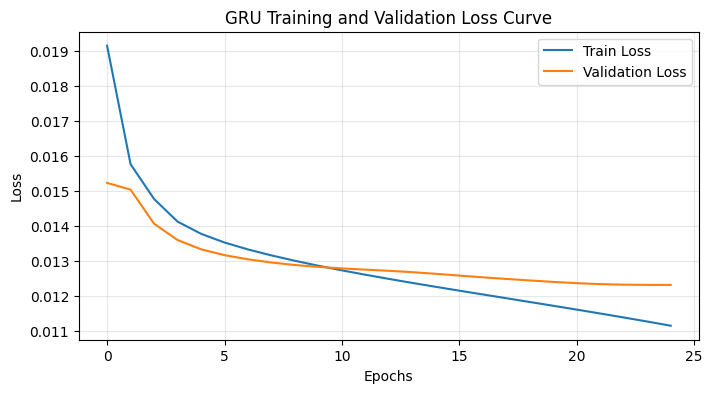

In [ ]:
# GRU Training vs Validation Loss
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title("GRU Training and Validation Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Inverse scaling the data and GRU Prediction
y_pred_gru_scaled = gru_model.predict(X_test)

y_pred_gru_log = scaler.inverse_transform(
    np.hstack([
        y_pred_gru_scaled,
        np.zeros((y_pred_gru_scaled.shape[0], num_features - 1))
    ])
)[:, 0]

# Reverse log transform
y_pred_gru_final = np.expm1(y_pred_gru_log)


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
#Final result for GRU MODEL(RMSE and GRU)
rmse_gru = np.sqrt(mean_squared_error(y_test_final, y_pred_gru_final))
mae_gru  = mean_absolute_error(y_test_final, y_pred_gru_final)

print("GRU FINAL RMSE (kW):", rmse_gru)
print("GRU FINAL MAE  (kW):", mae_gru)


GRU FINAL RMSE (kW): 0.4660022527090748
GRU FINAL MAE  (kW): 0.30717183797111514


In [ ]:
r2_gru = r2_score(y_test_final, y_pred_gru_final)

print("GRU R² Score:", r2_gru)


GRU R² Score: 0.5616741667603963


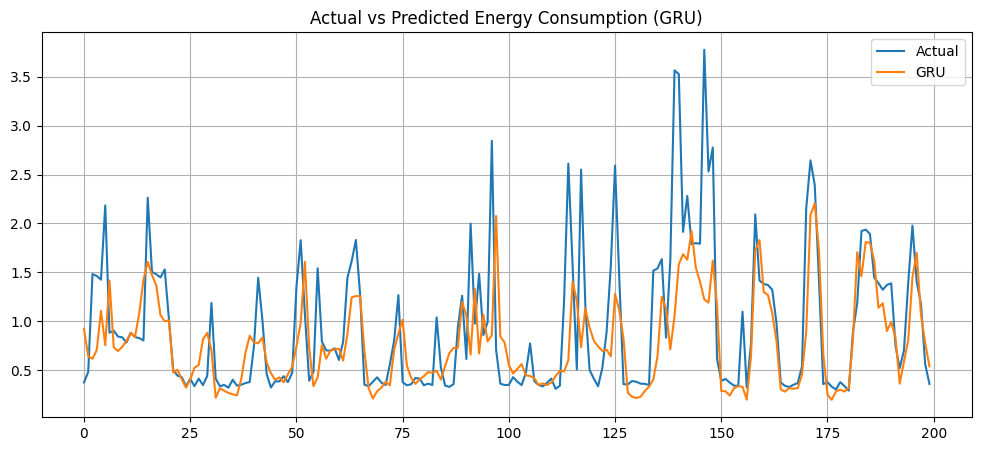

In [ ]:
# actual vs prediction graph
plt.figure(figsize=(12,5))
plt.plot(y_test_final[:200], label="Actual")
plt.plot(y_pred_gru_final[:200], label="GRU")
plt.title("Actual vs Predicted Energy Consumption (GRU)")
plt.legend()
plt.grid()
plt.show()


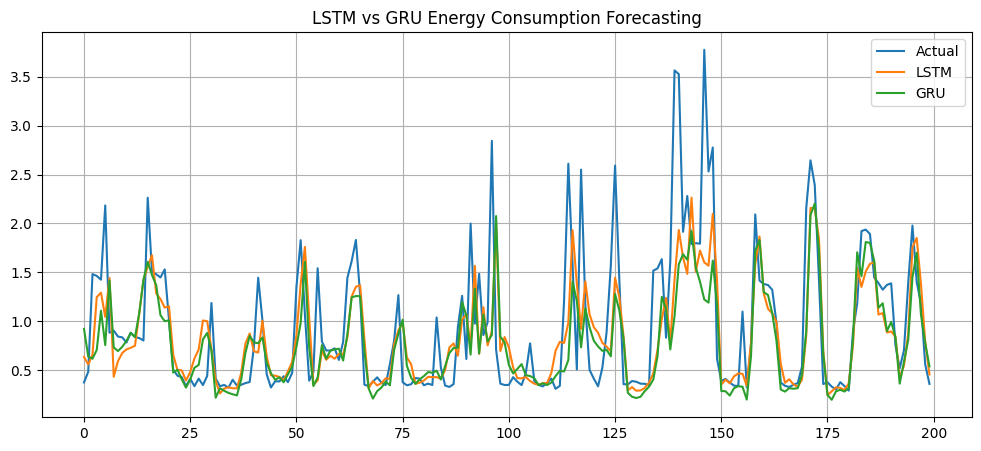

In [ ]:
# actual vs prediction graph
plt.figure(figsize=(12,5))
plt.plot(y_test_final[:200], label="Actual")
plt.plot(y_pred_final[:200], label="LSTM")
plt.plot(y_pred_gru_final[:200], label="GRU")
plt.title("LSTM vs GRU Energy Consumption Forecasting")
plt.legend()
plt.grid()
plt.show()


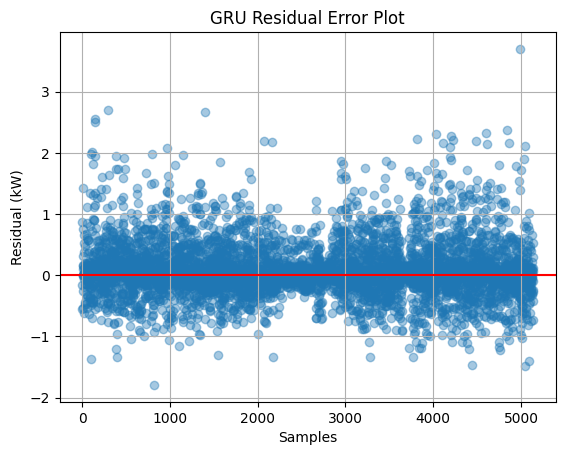

In [ ]:
# Residual Error Plot (GRU)
residuals_gru = y_test_final - y_pred_gru_final

plt.scatter(range(len(residuals_gru)), residuals_gru, alpha=0.4)
plt.axhline(0, color='red')
plt.title("GRU Residual Error Plot")
plt.xlabel("Samples")
plt.ylabel("Residual (kW)")
plt.grid()
plt.show()


In [ ]:
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'RMSE (kW)': [rmse, rmse_gru],
    'MAE (kW)': [mae, mae_gru],
    'R² Score': [r2, r2_gru]
})

results


,Model,RMSE (kW),MAE (kW),R² Score
0,LSTM,0.461664,0.307460,0.569798
1,GRU,0.466002,0.307172,0.561674
